In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

- Drop players with more than one team
- Index with tuple for Rk & Player
- Drop the following columns:
     - Unuseful information: Rk, GT, MaxVotes, Tm, Pos
     - Correlation with another feature: FG_tot, 3PA_tot, 2PA_tot, FGA_rank_tot
     - With target information: Votes
- LabelEncode for Player, Pos and Team
- Separate types of columns

In [4]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [5]:
pipe = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [6]:
df = pipe.fit_transform(df)

In [7]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [8]:
len(df[df['Season'] > 2015]) / len(df)

0.17507805847289243

In [9]:
val_df = df[df['Season'] > 2015]
dev_df = df[df['Season'] <= 2015]

In [10]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .35)

In [11]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [12]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [13]:
mlflow.set_experiment('NBA MVP prediction Elastic Net')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/2', experiment_id='2', lifecycle_stage='active', name='NBA MVP prediction Elastic Net', tags={}>

In [14]:
param_grid = {
    'alpha': [.5, .7, .9], 
    'l1_ratio': [.1, .5, .7, .9], 
    }

In [15]:
# model.predict(StandardScaler().fit_transform(X_val))

In [16]:
# for key, value in datasets.items():
#     datasets[key] = pd.DataFrame(StandardScaler().fit_transform(value), columns = value.columns, index = value.index)

In [17]:
with mlflow.start_run():
    estimator = ElasticNet()

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    params = model.get_params()

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_enet(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   5.7s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   4.2s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   2.6s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   2.1s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   2.2s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   1.8s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   1.8s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   2.1s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   1.8s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   2.1s
[CV] END ............................alpha=0.5, l1_ratio=0.5; total time=   1.0s
[CV] END ............................alpha=0.5

2022/07/17 12:34:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpm8pvvrc9\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [18]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.087968,0.079143,0.069558
R2,0.541004,0.285501,-0.510968


In [19]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [20]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.495846
263,2016,Kawhi Leonard,0.484,0.206663
222,2016,LeBron James,0.482,0.312925
452,2016,Russell Westbrook,0.371,0.341718
126,2016,Kevin Durant,0.112,0.376198
348,2016,Chris Paul,0.082,0.224146
167,2016,Draymond Green,0.038,0.180173
266,2016,Damian Lillard,0.020,0.193038
178,2016,James Harden,0.007,0.398827


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.612326
173,2017,James Harden,0.746,0.540008
261,2017,Kawhi Leonard,0.495,0.299208
221,2017,LeBron James,0.330,0.383105
425,2017,Isaiah Thomas,0.080,0.319029
98,2017,Stephen Curry,0.051,0.326241
16,2017,Giannis Antetokounmpo,0.007,0.327911
453,2017,John Wall,0.007,0.270160
100,2017,Anthony Davis,0.002,0.391137


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.450199
249,2018,LeBron James,0.731,0.487494
122,2018,Anthony Davis,0.441,0.420328
298,2018,Damian Lillard,0.205,0.279305
508,2018,Russell Westbrook,0.075,0.364624
16,2018,Giannis Antetokounmpo,0.074,0.351722
143,2018,Kevin Durant,0.065,0.329958
130,2018,DeMar DeRozan,0.032,0.199815
7,2018,LaMarcus Aldridge,0.006,0.164591


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.486772
207,2019,James Harden,0.768,0.614336
184,2019,Paul George,0.352,0.359164
270,2019,Nikola Jokić,0.210,0.304776
124,2019,Stephen Curry,0.173,0.297642
305,2019,Damian Lillard,0.068,0.314291
155,2019,Joel Embiid,0.049,0.343747
150,2019,Kevin Durant,0.025,0.375455
301,2019,Kawhi Leonard,0.013,0.239032


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.463649
251,2020,LeBron James,0.746,0.359684
199,2020,James Harden,0.363,0.504315
134,2020,Luka Dončić,0.198,0.364745
294,2020,Kawhi Leonard,0.166,0.261483
123,2020,Anthony Davis,0.081,0.305872
396,2020,Chris Paul,0.026,0.187400
297,2020,Damian Lillard,0.023,0.351351
262,2020,Nikola Jokić,0.018,0.258033


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.444738
146,2021,Joel Embiid,0.580,0.258314
116,2021,Stephen Curry,0.449,0.389076
12,2021,Giannis Antetokounmpo,0.345,0.396055
396,2021,Chris Paul,0.138,0.199058
130,2021,Luka Dončić,0.042,0.365309
297,2021,Damian Lillard,0.038,0.332672
421,2021,Julius Randle,0.020,0.267822
439,2021,Derrick Rose,0.010,0.055598


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.028175
5,2016,Alexis Ajinça,0.0,0.018204
6,2016,Cole Aldrich,0.0,0.030183
7,2016,LaMarcus Aldridge,0.0,0.092731
8,2016,Cliff Alexander,0.0,0.014491
...,...,...,...,...
536,2021,Delon Wright,0.0,0.105743
537,2021,Thaddeus Young,0.0,0.104728
538,2021,Trae Young,0.0,0.241453


In [21]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
19,2016,Giannis Antetokounmpo,0.0,0.107418
21,2016,Carmelo Anthony,0.0,0.141349
72,2016,Jimmy Butler,0.0,0.124383
97,2016,DeMarcus Cousins,0.0,0.244813
107,2016,Anthony Davis,0.0,0.179350
...,...,...,...,...
522,2021,Andrew Wiggins,0.0,0.132504
528,2021,Zion Williamson,0.0,0.234001
536,2021,Delon Wright,0.0,0.105743


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

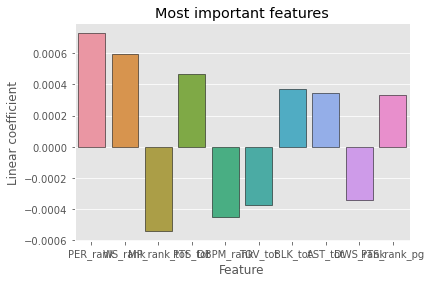

In [22]:
mod.display_linear_coef(best_model)

In [23]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

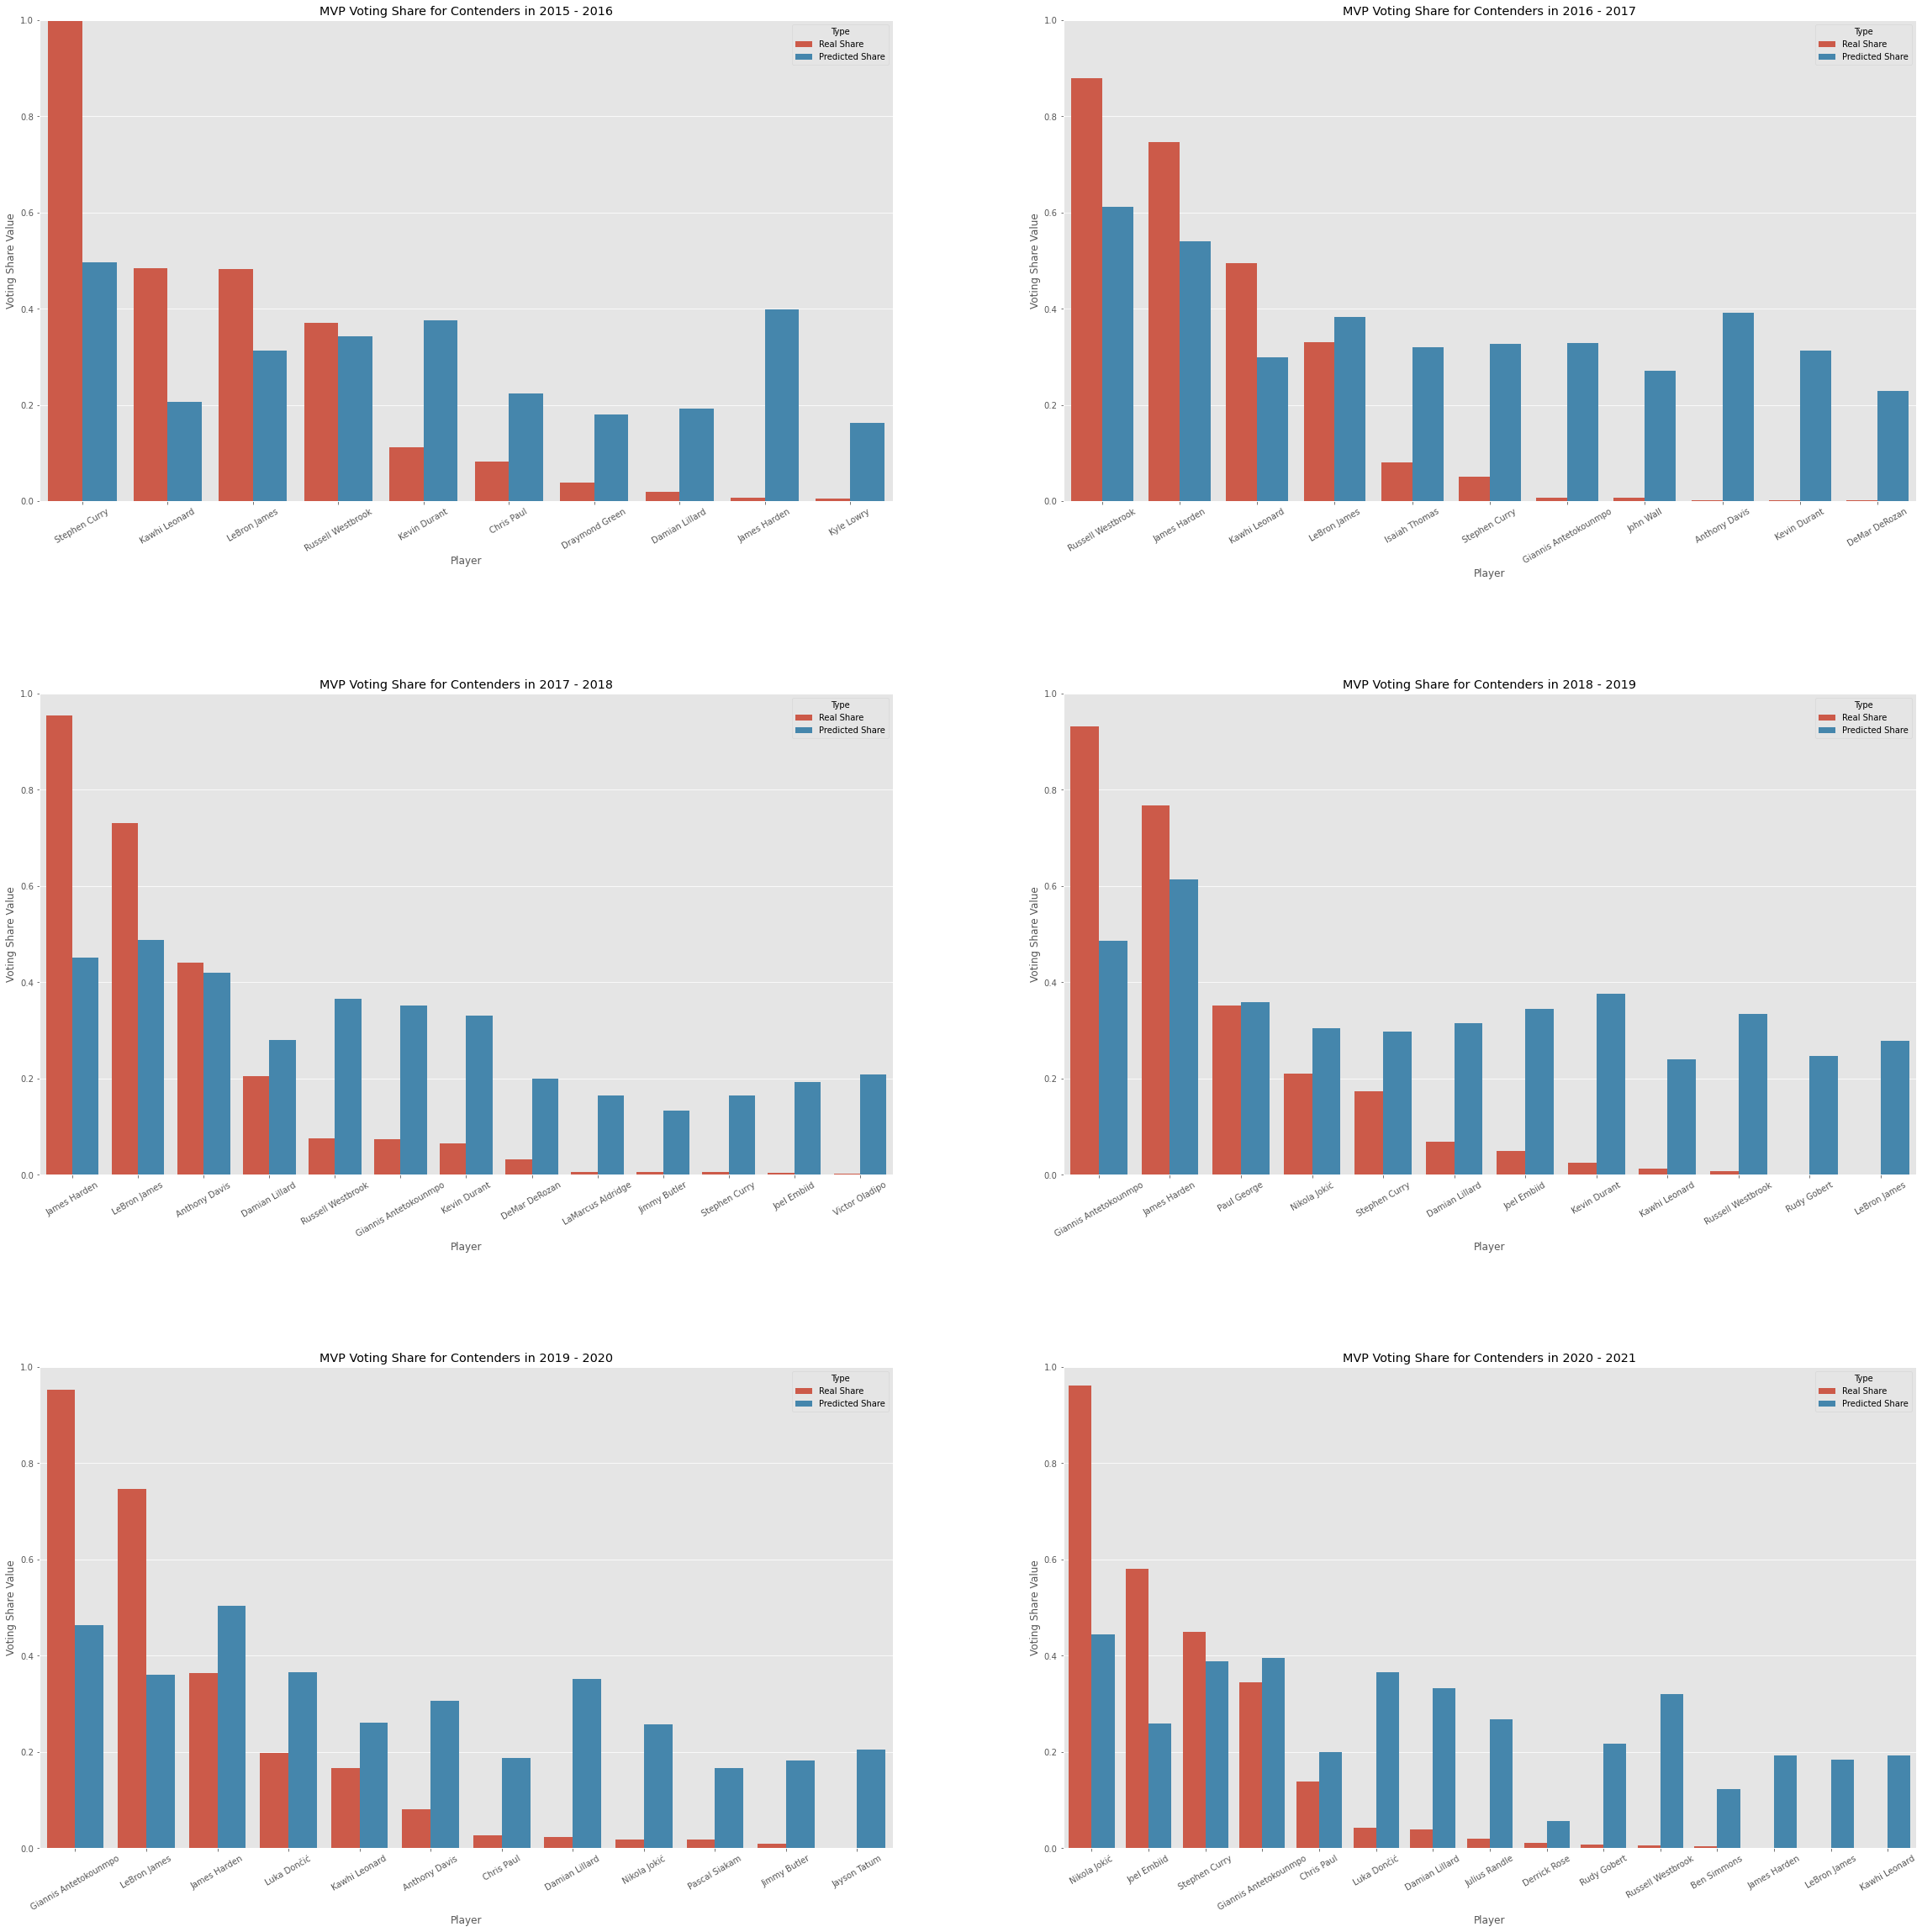

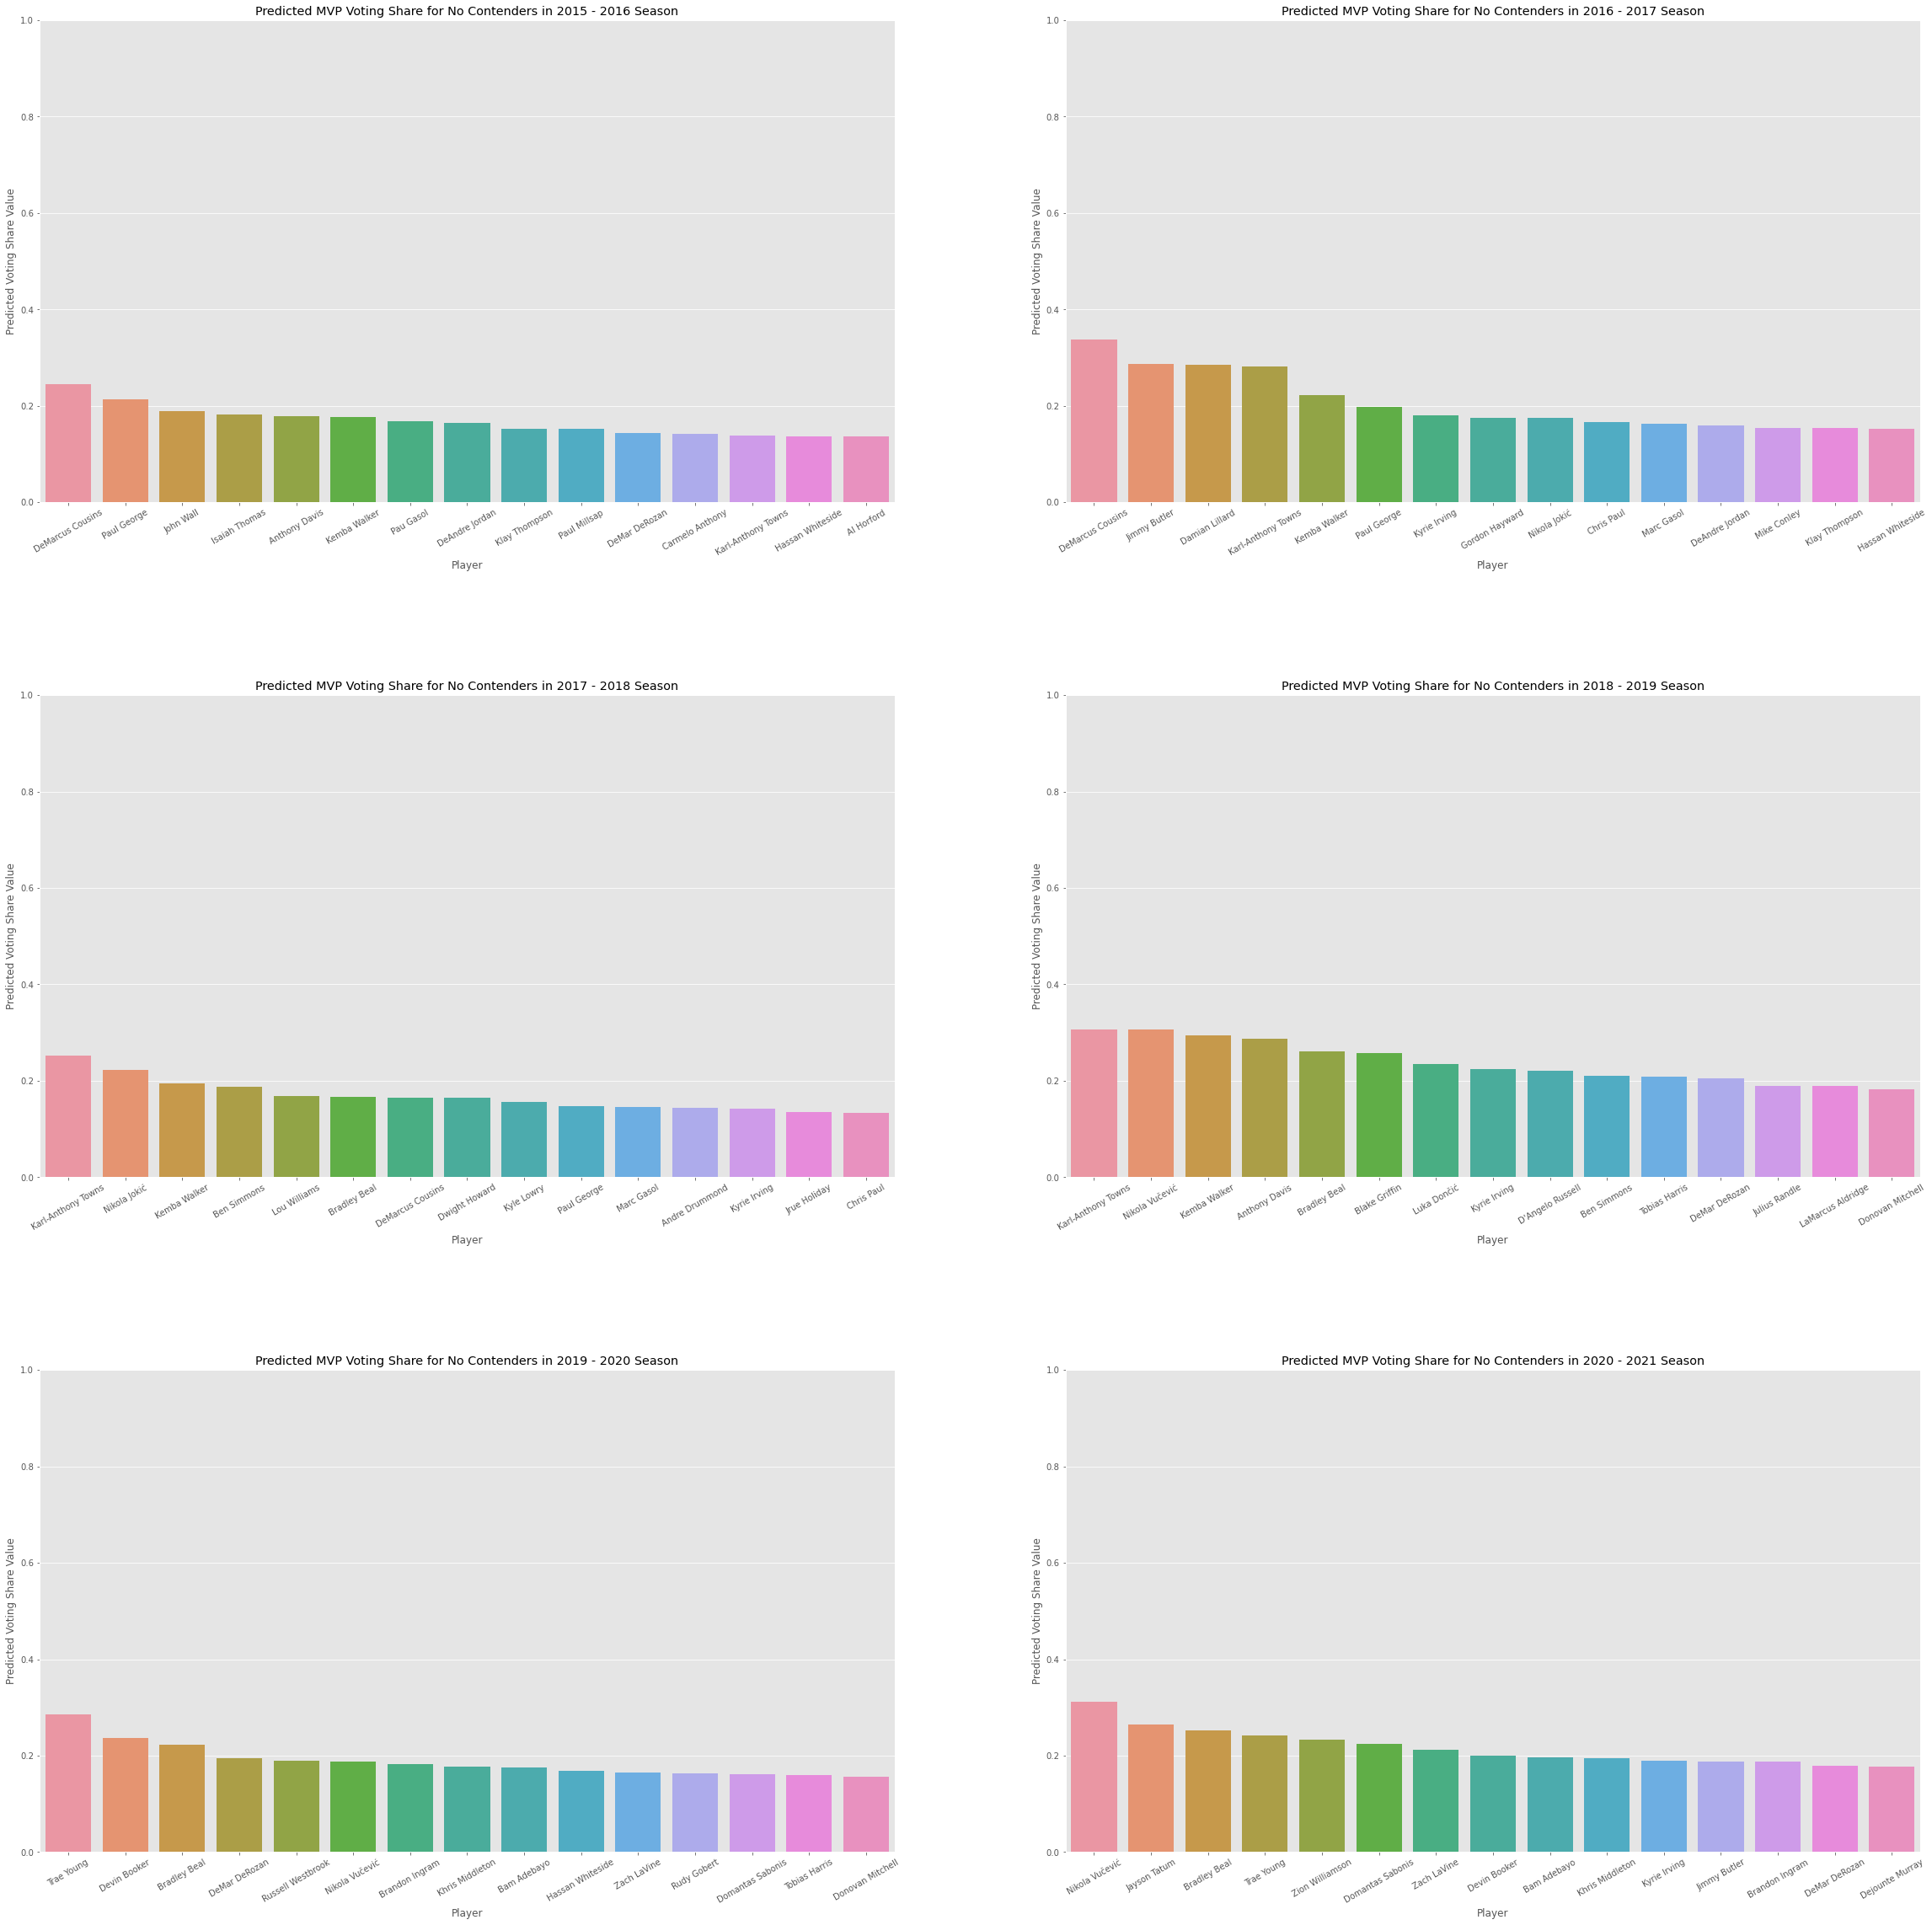

In [24]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [25]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [26]:
# top_features[top_features['Importance'] > 0.005]